# Titanic Classification Models

In this notebook we will look at multiple classification models and try tune their parameters in order to select the best model to submit to the Titanic dataset competition.

### Data Preprocessing

In [1]:
# Importing basic libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

# Importing plotting libraries
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

# Importing sklearn support libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

# Importing model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Setting parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Functions used to create and return a confusion matrix and an accuracy score for each model
def confusion_matrix(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    return metrics.confusion_matrix(y_test, y_pred)


def accuracy_score(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)

In [3]:
# Read the data from the csv and print the first 5 entries of the training data
data = pd.read_csv("data/train.csv", index_col = "PassengerId")
comp_data = pd.read_csv("data/test.csv", index_col = "PassengerId")
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Drop Columns not to be used
data = data.drop(["Name", "Ticket", "Cabin"], axis=1)
comp_data = comp_data.drop(["Name", "Ticket", "Cabin"], axis=1)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [5]:
# Replacing nans with mean age for missing ages
# data["Age"] = data["Age"].fillna(data["Age"].mean())

# Replacing the missing age with the median age based on the passengers class 
data["Age"] = data.groupby("Pclass")["Age"].apply(lambda x:  x.fillna(round(x.median())))
comp_data["Age"] = comp_data.groupby("Pclass")["Age"].apply(lambda x:  x.fillna(round(x.median())))

# Replacing the missing port with the port of Southhampton as that is where the majority of passengers boarded
data["Embarked"] = data["Embarked"].fillna("S")
comp_data["Embarked"] = comp_data["Embarked"].fillna("S")

# Replacing the missing fare with the mean of classes fare
comp_data["Fare"] = comp_data.groupby("Pclass")["Fare"].apply(lambda x:  x.fillna(round(x.mean())))

# Make sure there are no missing entries
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [6]:
# Encode Pclass, Sex, and Embarked into dummy variables
data = pd.concat([data, pd.get_dummies(data["Pclass"], prefix='Pclass')],axis=1)
data = pd.concat([data, pd.get_dummies(data["Sex"], prefix='Sex')],axis=1)
data = pd.concat([data, pd.get_dummies(data["Embarked"], prefix='Embarked')],axis=1)

comp_data = pd.concat([comp_data, pd.get_dummies(comp_data["Pclass"], prefix='Pclass')],axis=1)
comp_data = pd.concat([comp_data, pd.get_dummies(comp_data["Sex"], prefix='Sex')],axis=1)
comp_data = pd.concat([comp_data, pd.get_dummies(comp_data["Embarked"], prefix='Embarked')],axis=1)

# Drop the encoded columns
data = data.drop(["Pclass", "Sex", "Embarked"], axis=1)
comp_data = comp_data.drop(["Pclass", "Sex", "Embarked"], axis=1)

data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [7]:
# Seperate the data into training data and test data
y = data["Survived"]
X = data.drop(["Survived"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# Apply a standard scalar across the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Logistic Regression

In [9]:
print("Logistic Regression")
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
cm = confusion_matrix(classifier, X_test, y_test)
ac = accuracy_score(classifier, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % ac)

Logistic Regression
Confusion Matrix:
 [[95 15]
 [19 50]]
Accuracy Score: 0.810


Using basic Logistic Regression as a baseline we can achieve an accuracy score of 81%

### K Nearest Neighbors

K Nearest Neighbors
Maximum: 175
Confusion Matrix:
 [[109   1]
 [ 29  40]]
Accuracy Score: 0.832


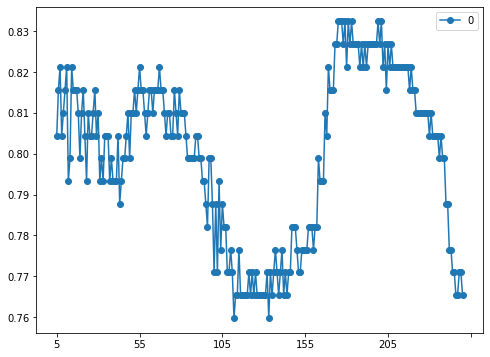

In [10]:
print("K Nearest Neighbors")

neighbors = range(4, 250)

results = pd.DataFrame()
for i in neighbors:
    classifier = KNeighborsClassifier(n_neighbors=i+1, metric="minkowski", p=2)
    classifier.fit(X_train, y_train)
    ac = accuracy_score(classifier, X_test, y_test)
    results[str(i+1)] = [ac]

results.T.plot(marker='o')
print("Maximum: %i" % int(results.idxmax(axis=1)[0]))

classifier = KNeighborsClassifier(n_neighbors=int(results.idxmax(axis=1)[0]), metric="minkowski", p=2)
classifier.fit(X_train, y_train)
cm = confusion_matrix(classifier, X_test, y_test)
ac = accuracy_score(classifier, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % ac)

Testing out the K Nearest Neighbors algorithm with multiple values for the number of neighbors we can see that the max accuracy score is achieved at ~175 neighbors with another local peak at ~60 neighbors. 175 seems like perhaps it is a little high for a number of neighbors as there are only ~800 entries in the dataset so I would suspect that there is some overfitting meaning that a more reasonable value to pick would be either ~10 or maybe ~60 even though it would give a lower accuracy score overall. 

### Support Vector Machine

Support Vector Machine
Maximum: poly

Confusion Matrix:
 [[105   5]
 [ 26  43]]
Accuracy Score: 0.827


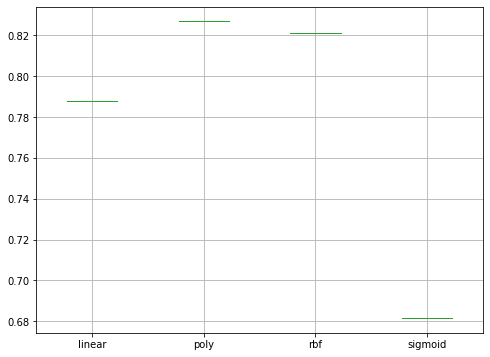

In [11]:
print("Support Vector Machine")
results = pd.DataFrame()
kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    classifier = SVC(kernel=kernel, random_state=0)
    classifier.fit(X_train, y_train)
    ac = accuracy_score(classifier, X_test, y_test)
    results[kernel] = [ac]

results.boxplot()
print("Maximum: %s" % results.idxmax(axis=1)[0])
print()

classifier = SVC(kernel="poly", random_state=0)
classifier.fit(X_train, y_train)
cm = confusion_matrix(classifier, X_test, y_test)
ac = accuracy_score(classifier, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % ac)

From the results it appears that the best SVM kernal for this dataset is either a polynomial function or the radial basis function. The degree of the polynomial function can also be a hyperparameter that can be set so that will be discussed in the next section. 

Support Vector Machine - Poly
Maximum: 3

Confusion Matrix:
 [[105   5]
 [ 26  43]]
Accuracy Score: 0.827


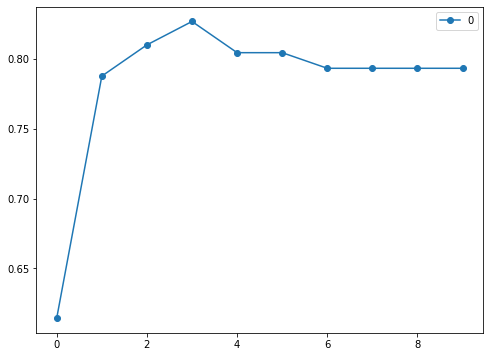

In [12]:
print("Support Vector Machine - Poly")
results = pd.DataFrame()
orders = range(10)

for order in orders:
    classifier = SVC(kernel="poly", degree=order, random_state=0)
    classifier.fit(X_train, y_train)
    ac = accuracy_score(classifier, X_test, y_test)
    results[order] = [ac]

results.T.plot(marker='o')
print("Maximum: %s" % results.idxmax(axis=1)[0])
print()

classifier = SVC(kernel="poly", degree=results.idxmax(axis=1)[0], random_state=0)
classifier.fit(X_train, y_train)
cm = confusion_matrix(classifier, X_test, y_test)
ac = accuracy_score(classifier, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % ac)

After testing the differnt degrees from 0-9 is is clear that by chance the default 3rd order is the best performing.

### Naive Bayes

In [13]:
print("Naive Bayes")
classifier = GaussianNB()
classifier.fit(X_train, y_train)
cm = confusion_matrix(classifier, X_test, y_test)
ac = accuracy_score(classifier, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % ac)

Naive Bayes
Confusion Matrix:
 [[89 21]
 [15 54]]
Accuracy Score: 0.799


### Decision Tree

Decision Tree
Mean: 0.778


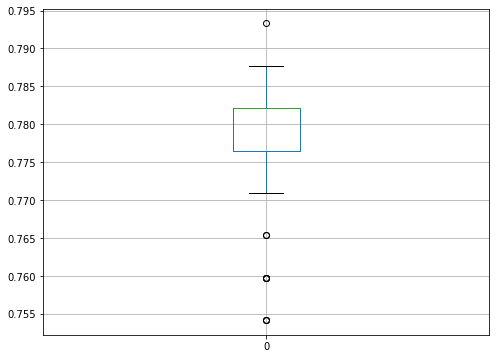

In [14]:
print("Decision Tree")
ac_scores = []
for i in range(50):
    
    classifier = DecisionTreeClassifier(criterion="entropy")
    classifier.fit(X_train, y_train)
    cm = confusion_matrix(classifier, X_test, y_test)
    ac = accuracy_score(classifier, X_test, y_test)
#     print("Confusion Matrix:\n %s" % cm)
#     print("Accuracy Score: %.3f" % ac)
    ac_scores.append(ac)

pd.DataFrame(ac_scores).boxplot()
print("Mean: %.3f" % np.mean(ac_scores))

### Random Forest

Random Forest
Confusion Matrix:
 [[100  10]
 [ 19  50]]
Accuracy Score: 0.838


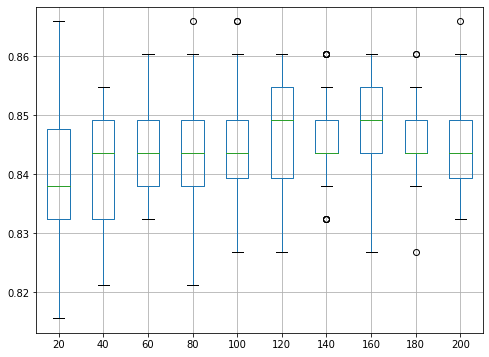

In [15]:
print("Random Forest")
results = pd.DataFrame()

trees = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
for tree in trees:
    ac_scores = []
    for i in range(50):
        classifier = RandomForestClassifier(n_estimators=tree, criterion="entropy")
        classifier.fit(X_train, y_train)
        ac = accuracy_score(classifier, X_test, y_test)
        ac_scores.append(ac)
    results[str(tree)] = ac_scores

results.boxplot()

classifier = RandomForestClassifier(n_estimators=100, criterion="entropy")
classifier.fit(X_train, y_train)
cm = confusion_matrix(classifier, X_test, y_test)
ac = accuracy_score(classifier, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % ac)

The Random Forest model is the hardest to evaluate as there is significant variability between trials but after observing several runs it was clear that a number of estimators of ~100 was the best balance between highest mean and narrowest spread of resutls. 

### Final Result

After considering all the various models, their strengths and weaknesses, the Random Forest was picked as the best model for this application.

In [16]:
comp_X = sc.transform(comp_data)

comp_y = {}
for index, row in comp_data.iterrows():
    comp_y[index] = classifier.predict(sc.transform([row]))[0]

import csv
with open('results/result.csv','w') as f:
    w = csv.writer(f)
    w.writerows(comp_y.items())